In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
tf.__version__
from PIL import Image
import glob

from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization


## Image data loader and Exploration

In [2]:

image_list = []
for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive=True):
    filename = filepath.split("\\")[-1]
    signShape = filepath.split("\\")[1]
    signType = filepath.split("\\")[2]
    image_list.append((filepath, signShape, signType))
    
data = pd.DataFrame(data=image_list, columns=['image_path','signShape','signType'])

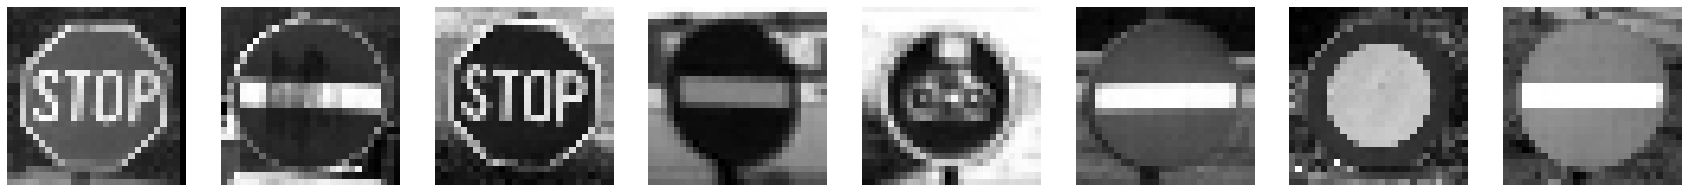

In [3]:
r_inx = np.random.choice(1000, 8)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(30,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,8,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [4]:
data_shape=data[['image_path','signShape']]
data_type=data[['image_path','signType']]


In [5]:
data_shape.shape

(3699, 2)

In [6]:
data_shape.head()

,image_path,signShape
0,trafficsigns_dataset\diamond\rightofway\00032_...,diamond
1,trafficsigns_dataset\diamond\rightofway\00032_...,diamond
2,trafficsigns_dataset\diamond\rightofway\00032_...,diamond
3,trafficsigns_dataset\diamond\rightofway\00037_...,diamond
4,trafficsigns_dataset\diamond\rightofway\00037_...,diamond


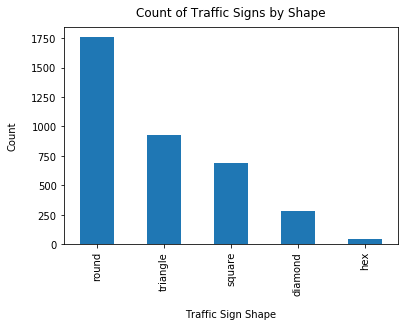

In [7]:
data_shape.signShape.value_counts().plot(kind='bar')
plt.xlabel("Traffic Sign Shape", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of Traffic Signs by Shape", y=1.02);

### Looking at the above graph we can see that this is an imbalance class problem. To tackle this we could use weighted model or do some data augmentation. 

In [8]:
data_shape.signShape.value_counts()

round       1760
triangle     926
square       688
diamond      282
hex           43
Name: signShape, dtype: int64

In [9]:
# Convert string labels to numeric
d = {'diamond':0,'hex':1,'round':2,'square':3,'triangle':4}
data_shape['labels_num'] = data_shape['signShape'].map(d, na_action='ignore')

## Data for Independent Evaluation

##### Independent Evaluation dataset pre processing

In [10]:
#fname=data_ind['image_path']

#import cv2
#import os

#for file in fname:
#    image = cv2.imread(file)
#    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#    resized = cv2.resize(gray, (28,28) , interpolation = cv2.INTER_AREA)
#    cv2.imwrite(os.path.join(file), resized)

In [11]:
image_list = []
for filepath in glob.glob('traffic_sign_data_independent_eval_new/*/*/*.png', recursive=True):
    filename = filepath.split("\\")[-1]
    signShape = filepath.split("\\")[1]
    signType = filepath.split("\\")[2]
    image_name=filepath.split("\\")[3]
    image_list.append((filepath, signShape, signType,image_name))
    
data_ind = pd.DataFrame(data=image_list, columns=['image_path','signShape','signType','image_name'])

data_ind_test=data_ind[['image_path','signShape']]

ind_tst_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

ind_test_generator = ind_tst_datagen.flow_from_dataframe(
    dataframe=data_ind_test,
    directory='./',
    x_col="image_path",
    y_col="signShape",
    target_size=(28, 28),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')


Found 173 validated image filenames belonging to 5 classes.


In [12]:
def ind_eval_m(history):
    ind_test_generator.reset()
    Y_pred = model.predict_generator(ind_test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(ind_test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['diamonds', 'hex', 'round','square','triangle']
    print(classification_report(ind_test_generator.classes, y_pred, target_names=target_names))

# Predict the shape of the traffic sign

#### Test Train validation Split

In [13]:
data_shape.head()

,image_path,signShape,labels_num
0,trafficsigns_dataset\diamond\rightofway\00032_...,diamond,0
1,trafficsigns_dataset\diamond\rightofway\00032_...,diamond,0
2,trafficsigns_dataset\diamond\rightofway\00032_...,diamond,0
3,trafficsigns_dataset\diamond\rightofway\00037_...,diamond,0
4,trafficsigns_dataset\diamond\rightofway\00037_...,diamond,0


In [14]:
X=data_shape[['image_path']]
Y=data_shape[['signShape']]

In [15]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY= train_test_split(X,Y,test_size=0.1,random_state=100)


In [16]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(3329, 1)
(370, 1)
(3329, 1)
(370, 1)


In [17]:
testY.signShape.value_counts()

round       171
triangle     94
square       75
diamond      21
hex           9
Name: signShape, dtype: int64

In [18]:
trainY.signShape.value_counts()

round       1589
triangle     832
square       613
diamond      261
hex           34
Name: signShape, dtype: int64

In [19]:
trainX1, valX, trainY1, valY= train_test_split(trainX,trainY,test_size=0.2,random_state=231)

In [20]:
print(trainX1.shape)
print(valX.shape)
print(trainY1.shape)
print(valY.shape)


(2663, 1)
(666, 1)
(2663, 1)
(666, 1)


In [21]:
trainY1['signShape'].value_counts()

round       1258
triangle     674
square       491
diamond      210
hex           30
Name: signShape, dtype: int64

In [22]:
train_df=pd.concat([trainX1,trainY1],axis=1)
val_df=pd.concat([valX,valY],axis=1)
test_df=pd.concat([testX,testY],axis=1)

In [23]:
N_train_images = train_df.shape[0]
N_val_images = val_df.shape[0]
N_test_images=test_df.shape[0]

In [24]:
print("Training data shape:   ",train_df.shape)
print("Validation data shape: ",val_df.shape)
print("Testing data shape:    ",test_df.shape)

Training data shape:    (2663, 2)
Validation data shape:  (666, 2)
Testing data shape:     (370, 2)


##### Calculating the weights for the model

In [25]:
from sklearn.utils import class_weight
ytrain = np.array(train_df['signShape'])
class_weights = class_weight.compute_class_weight('balanced', np.unique(ytrain), ytrain)

## Creating Test/Train/Validation Data Generators

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
tst_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

##### Train Data Generator

In [27]:
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./',
    x_col="image_path",
    y_col="signShape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')

Found 2663 validated image filenames belonging to 5 classes.


##### Validation Data Generator

In [28]:
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./',
    x_col="image_path",
    y_col="signShape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')


Found 666 validated image filenames belonging to 5 classes.


##### Test Data Generator

In [29]:

test_generator = tst_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='./',
    x_col="image_path",
    y_col="signShape",
    target_size=(28, 28),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

Found 370 validated image filenames belonging to 5 classes.


### Defining Neural Net Architecture with 1 hidden layer using ReLU/sigmoid/softmax activations

###### Model 1

In [40]:
input_ = Input(shape=(28, 28, 3))
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)
#Hidden layer
h = Dense(64)(x)
h = Activation('sigmoid')(h)
# Output layer
out_ = Dense(5)(h)
out_ = Activation('softmax')(out_)

model_1 = Model(inputs=input_, outputs=out_) # Setup the model

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_1.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

model_1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_9 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_10 (Activation)   (None, 5)                 0   

###### Model 2

In [41]:
input_ = Input(shape=(28, 28, 3))
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)
#Hidden layer
h = Dense(64)(x)
h = Activation('relu')(h)
# Output layer
out_ = Dense(5)(h)
out_ = Activation('softmax')(out_)

model_2 = Model(inputs=input_, outputs=out_) # Setup the model

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_2.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

model_2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_11 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_12 (Activation)   (None, 5)                 0   

#### Model 3 Including Regularization

In [42]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x) # reg for weight matrix 1
h = Activation('relu', name='hidden_layer')(h)

# Output layer
out_ = Dense(5,kernel_regularizer=regularizers.l2(0.01))(h) # reg for weight matrix 2
out_ = Activation('softmax')(out_)

# Define model
model_reg = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_reg.summary()

# Creating a model for feature vizualization (will be explained later)
hidden_features = Model(inputs=input_, outputs=h)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                50240     
_________________________________________________________________
hidden_layer (Activation)    (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0   

###### Model 4  Trying drop outs, Model 5 using adam optimizer

In [43]:

# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x) 
h = Activation('relu')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(5)(h) 
out_ = Activation('softmax')(out_)

# Define model
model_drop = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])



model_drop.summary()




# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = (lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784


# Hidden layer
h = Dense(64)(x) 
h = Activation('relu')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(5)(h) 
out_ = Activation('softmax')(out_)

# Define model using adam optimizer
model_drop_a = Model(inputs=input_, outputs=out_)


model_drop_a.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])


model_drop_a.summary()



Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325

##### Creating model functions

In [34]:
def calculate_losses(model_, data_generator_, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because# the generator loops indefinitely
            break
    return np.mean(loss_hold), np.mean(acc_hold)

In [35]:
def train_model(model_, num_epoch=100, verbose=1):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [36]:



def train_model_weighted(model_, num_epoch=100, verbose=1):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y, 
                                              class_weight=class_weights) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [37]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])
    plt.show()

In [38]:
#Confution Matrix and Classification Report

def eval_m(mod):
    test_generator.reset()
    Y_pred = mod.predict_generator(test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['diamonds', 'hex', 'round','square','triangle']
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

*******************************CNN model Start************************************




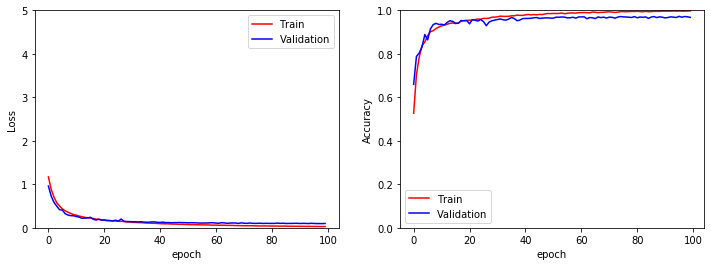

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[ 19   0   1   0   1]
 [  0   7   2   0   0]
 [  0   0 168   1   2]
 [  1   0   1  71   2]
 [  0   0   4   0  90]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.95      0.90      0.93        21
         hex       1.00      0.78      0.88         9
       round       0.95      0.98      0.97       171
      square       0.99      0.95      0.97        75
    triangle       0.95      0.96      0.95        94

    accuracy                           0.96       370
   macro avg       0.97      0.91      0.94       370
weighted avg       0.96      0.96      0.96       370



**********Independ evealuation result model
Confusion Matrix
[[ 8  0 16  0  0]
 [ 0  1 19  1  0]
 [ 8  0 54 19  1]
 [ 1  0  6  8  2]
 [ 0  0  8  0 21]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.47      0.33      0.39  

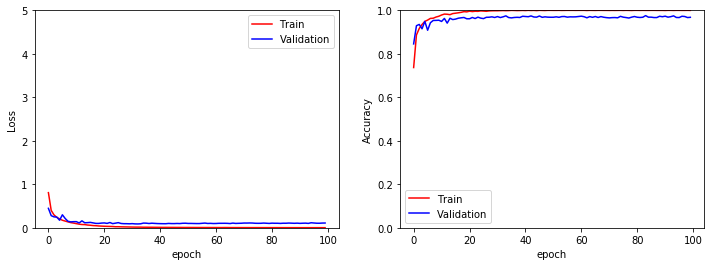

Confusion Matrix
[[ 20   0   0   0   1]
 [  0   8   1   0   0]
 [  1   0 168   1   1]
 [  1   0   0  74   0]
 [  0   0   2   0  92]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.91      0.95      0.93        21
         hex       1.00      0.89      0.94         9
       round       0.98      0.98      0.98       171
      square       0.99      0.99      0.99        75
    triangle       0.98      0.98      0.98        94

    accuracy                           0.98       370
   macro avg       0.97      0.96      0.96       370
weighted avg       0.98      0.98      0.98       370



**********Independ evealuation result model_1
Confusion Matrix
[[10  0 14  0  0]
 [ 0  0 20  1  0]
 [10  0 51 19  2]
 [ 2  0  3 10  2]
 [ 0  0  4  0 25]]
Classification Report


C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    diamonds       0.45      0.42      0.43        24
         hex       0.00      0.00      0.00        21
       round       0.55      0.62      0.59        82
      square       0.33      0.59      0.43        17
    triangle       0.86      0.86      0.86        29

    accuracy                           0.55       173
   macro avg       0.44      0.50      0.46       173
weighted avg       0.50      0.55      0.52       173

*******************************CNN model_1 END************************************
*******************************CNN model_2 Start************************************




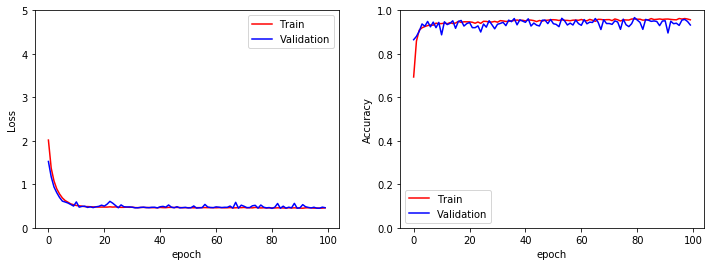

Confusion Matrix
[[ 15   0   6   0   0]
 [  0   2   7   0   0]
 [  0   0 170   0   1]
 [  0   0   3  71   1]
 [  0   0   5   1  88]]
Classification Report
              precision    recall  f1-score   support

    diamonds       1.00      0.71      0.83        21
         hex       1.00      0.22      0.36         9
       round       0.89      0.99      0.94       171
      square       0.99      0.95      0.97        75
    triangle       0.98      0.94      0.96        94

    accuracy                           0.94       370
   macro avg       0.97      0.76      0.81       370
weighted avg       0.94      0.94      0.93       370



**********Independ evealuation result model_2
Confusion Matrix
[[ 7  0 17  0  0]
 [ 0  0 20  1  0]
 [ 0  0 69 13  0]
 [ 1  0  8  6  2]
 [ 0  0 12  0 17]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.88      0.29      0.44        24
         hex       0.00      0.00      0.00        21
       round   

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


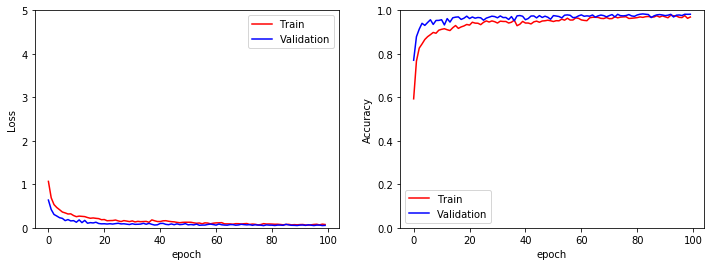

Confusion Matrix
[[ 19   0   1   0   1]
 [  0   8   1   0   0]
 [  1   0 168   1   1]
 [  0   0   0  75   0]
 [  0   0   1   0  93]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.95      0.90      0.93        21
         hex       1.00      0.89      0.94         9
       round       0.98      0.98      0.98       171
      square       0.99      1.00      0.99        75
    triangle       0.98      0.99      0.98        94

    accuracy                           0.98       370
   macro avg       0.98      0.95      0.97       370
weighted avg       0.98      0.98      0.98       370



**********Independ evealuation result model_4
Confusion Matrix
[[ 9  0 15  0  0]
 [ 0  1 18  1  1]
 [ 6  0 53 19  4]
 [ 0  0  3  9  5]
 [ 0  0  2  0 27]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.60      0.38      0.46        24
         hex       1.00      0.05      0.09        21
       round   

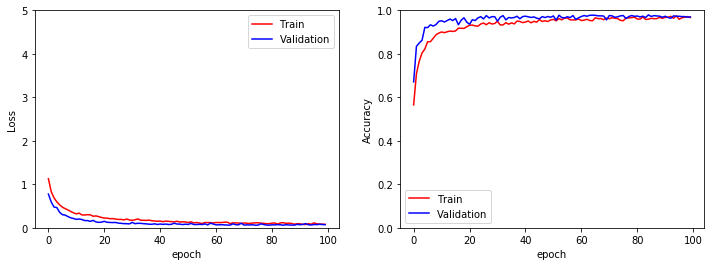

Confusion Matrix
[[ 18   0   2   0   1]
 [  0   5   4   0   0]
 [  1   0 168   2   0]
 [  0   0   1  73   1]
 [  0   0   2   1  91]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.95      0.86      0.90        21
         hex       1.00      0.56      0.71         9
       round       0.95      0.98      0.97       171
      square       0.96      0.97      0.97        75
    triangle       0.98      0.97      0.97        94

    accuracy                           0.96       370
   macro avg       0.97      0.87      0.90       370
weighted avg       0.96      0.96      0.96       370



**********Independ evealuation result model_5
Confusion Matrix
[[ 9  0 15  0  0]
 [ 0  0 20  1  0]
 [ 4  0 58 18  2]
 [ 0  0  3 10  4]
 [ 1  0  6  0 22]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.64      0.38      0.47        24
         hex       0.00      0.00      0.00        21
       round   

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
models_list=[model_1,model_2,model_reg,model_drop,model_drop_a]
for model in models_list:
    print("*******************************CNN" , model.name, "Start************************************")
    print("\n")
    res = train_model(model, num_epoch=100, verbose=0)
    plot_results(res)
    eval_m(model)
    print("\n")
    print("**********Independ evealuation result",model.name)
    ind_eval_m(model)
    print("*******************************CNN" , model.name, "END************************************")


The above model seems to overfit since the train accuracy and validation accuracy grew apart as we increased the epochs. The model is overlearning the train data and performing not so good on the validation data. In the following part I have included some regularization to reduce overfitting

*******************************CNN model_6 Start************************************




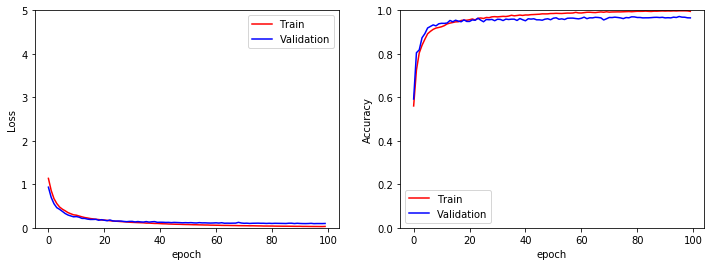

Confusion Matrix
[[ 20   0   0   0   1]
 [  0   9   0   0   0]
 [  1   0 166   2   2]
 [  1   0   1  70   3]
 [  0   0   2   0  92]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.91      0.95      0.93        21
         hex       1.00      1.00      1.00         9
       round       0.98      0.97      0.98       171
      square       0.97      0.93      0.95        75
    triangle       0.94      0.98      0.96        94

    accuracy                           0.96       370
   macro avg       0.96      0.97      0.96       370
weighted avg       0.97      0.96      0.96       370



**********Independ evealuation result model_6
Confusion Matrix
[[10  0 14  0  0]
 [ 0  1 19  1  0]
 [14  0 47 20  1]
 [ 2  0  3  9  3]
 [ 0  0  2  0 27]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.38      0.42      0.40        24
         hex       1.00      0.05      0.09        21
       round   

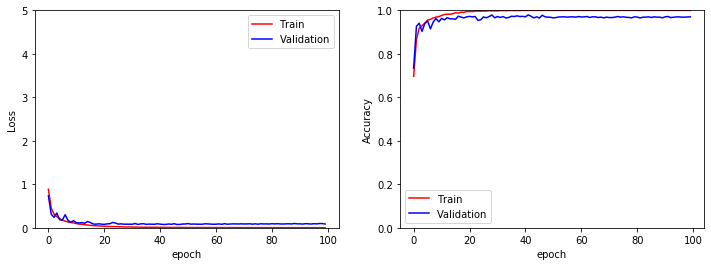

Confusion Matrix
[[ 21   0   0   0   0]
 [  0   8   1   0   0]
 [  1   0 168   2   0]
 [  1   0   1  73   0]
 [  0   0   2   0  92]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.91      1.00      0.95        21
         hex       1.00      0.89      0.94         9
       round       0.98      0.98      0.98       171
      square       0.97      0.97      0.97        75
    triangle       1.00      0.98      0.99        94

    accuracy                           0.98       370
   macro avg       0.97      0.96      0.97       370
weighted avg       0.98      0.98      0.98       370



**********Independ evealuation result model_7
Confusion Matrix
[[ 8  0 16  0  0]
 [ 0  0 20  1  0]
 [ 9  0 49 22  2]
 [ 2  0  2 10  3]
 [ 0  0  1  0 28]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.42      0.33      0.37        24
         hex       0.00      0.00      0.00        21
       round   

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


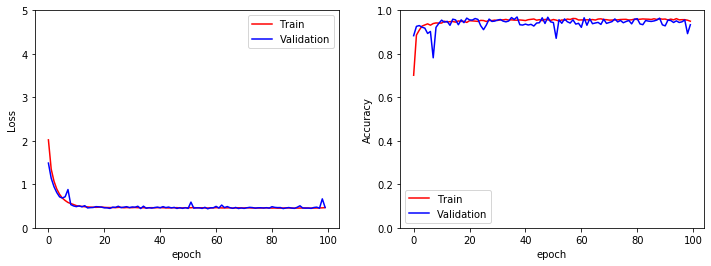

Confusion Matrix
[[ 15   0   6   0   0]
 [  0   2   7   0   0]
 [  0   0 171   0   0]
 [  0   0   4  70   1]
 [  0   0  11   1  82]]
Classification Report
              precision    recall  f1-score   support

    diamonds       1.00      0.71      0.83        21
         hex       1.00      0.22      0.36         9
       round       0.86      1.00      0.92       171
      square       0.99      0.93      0.96        75
    triangle       0.99      0.87      0.93        94

    accuracy                           0.92       370
   macro avg       0.97      0.75      0.80       370
weighted avg       0.93      0.92      0.91       370



**********Independ evealuation result model_8
Confusion Matrix
[[ 7  0 17  0  0]
 [ 0  0 20  1  0]
 [ 4  0 75  2  1]
 [ 1  0  8  6  2]
 [ 0  0 17  0 12]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.58      0.29      0.39        24
         hex       0.00      0.00      0.00        21
       round   

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


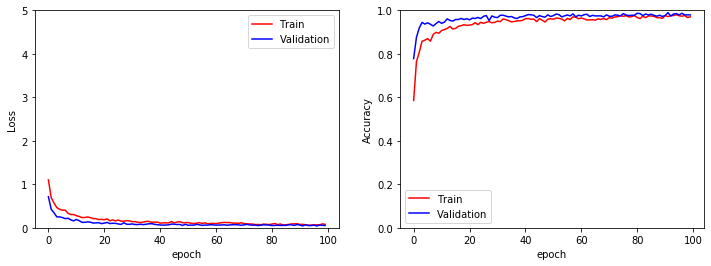

Confusion Matrix
[[ 19   0   1   0   1]
 [  0   7   2   0   0]
 [  0   0 170   1   0]
 [  0   0   0  75   0]
 [  0   0   2   0  92]]
Classification Report
              precision    recall  f1-score   support

    diamonds       1.00      0.90      0.95        21
         hex       1.00      0.78      0.88         9
       round       0.97      0.99      0.98       171
      square       0.99      1.00      0.99        75
    triangle       0.99      0.98      0.98        94

    accuracy                           0.98       370
   macro avg       0.99      0.93      0.96       370
weighted avg       0.98      0.98      0.98       370



**********Independ evealuation result model_10
Confusion Matrix
[[12  0 10  2  0]
 [ 0  0 20  1  0]
 [16  0 45 18  3]
 [ 2  0  3  9  3]
 [ 2  0  1  0 26]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.38      0.50      0.43        24
         hex       0.00      0.00      0.00        21
       round  

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


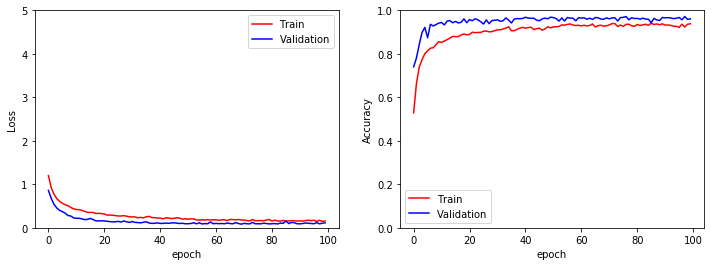

Confusion Matrix
[[ 16   0   4   0   1]
 [  0   4   5   0   0]
 [  0   0 171   0   0]
 [  0   0   1  72   2]
 [  0   0   5   0  89]]
Classification Report
              precision    recall  f1-score   support

    diamonds       1.00      0.76      0.86        21
         hex       1.00      0.44      0.62         9
       round       0.92      1.00      0.96       171
      square       1.00      0.96      0.98        75
    triangle       0.97      0.95      0.96        94

    accuracy                           0.95       370
   macro avg       0.98      0.82      0.87       370
weighted avg       0.95      0.95      0.95       370



**********Independ evealuation result model_11
Confusion Matrix
[[ 9  0 15  0  0]
 [ 0  0 20  1  0]
 [ 9  0 63 10  0]
 [ 2  0  5  8  2]
 [ 5  0  6  0 18]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.36      0.38      0.37        24
         hex       0.00      0.00      0.00        21
       round  

C:\Users\Akshay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
models_list=[model_1,model_2,model_reg,model_drop,model_drop_a]
for model in models_list:
    print("*******************************CNN" , model.name, "Start************************************")
    print("\n")
    res = train_model_weighted(model, num_epoch=100, verbose=0)
    plot_results(res)
    eval_m(model)
    print("\n")
    print("**********Independ evealuation result",model.name)
    ind_eval_m(model)
    print("\n")
    print("*******************************CNN" , model.name, "END************************************")


### New Sequential approach - Adding 2 hiden layers with maxPooling and reLU/Softmax activation with dropouts using a weighted model with sgd optimizer

In [49]:
def newplot(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [50]:
def ind_eval(history):
    ind_test_generator.reset()
    Y_pred = history.model.predict_generator(ind_test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(ind_test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['diamonds', 'hex', 'round','square','triangle']
    print(classification_report(ind_test_generator.classes, y_pred, target_names=target_names))

In [51]:

def create_1(model,opt='sgd'):
    model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(28,28,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))


    model.add(Dense(5, activation='softmax'))

    
    if opt=='sgd':
        
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    if opt=='adam':
        
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])



  ...
    to  
  ['...']
Confusion Matrix
[[ 20   0   0   0   1]
 [  1   8   0   0   0]
 [  0   1 170   0   0]
 [  0   0   0  75   0]
 [  0   0   1   0  93]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.95      0.95      0.95        21
         hex       0.89      0.89      0.89         9
       round       0.99      0.99      0.99       171
      square       1.00      1.00      1.00        75
    triangle       0.99      0.99      0.99        94

    accuracy                           0.99       370
   macro avg       0.96      0.96      0.96       370
weighted avg       0.99      0.99      0.99       370



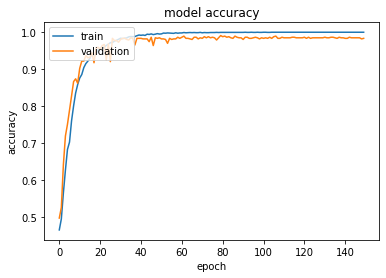

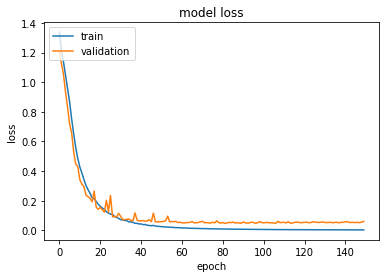

Confusion Matrix
[[16  0  8  0  0]
 [ 0 18  3  0  0]
 [ 5  0 68  8  1]
 [ 1  0  1 13  2]
 [ 1  0  3  0 25]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.70      0.67      0.68        24
         hex       1.00      0.86      0.92        21
       round       0.82      0.83      0.82        82
      square       0.62      0.76      0.68        17
    triangle       0.89      0.86      0.88        29

    accuracy                           0.81       173
   macro avg       0.81      0.80      0.80       173
weighted avg       0.82      0.81      0.81       173



********************same as above model with class weights and early stopping*************************


  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
Confusion Matrix
[[ 20   0   0   0   1]
 [  0   9   0   0   0]
 [  0   0 171   0   0]
 [  0   0   0  74   1]
 [  0   0   0   0  94]]
Classification Report
          

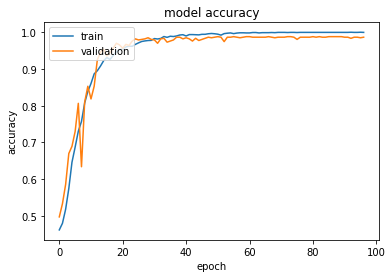

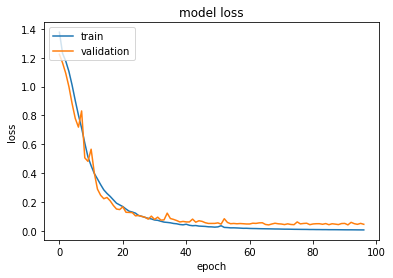

Confusion Matrix
[[17  0  7  0  0]
 [ 0  9 11  0  1]
 [ 5  0 65  9  3]
 [ 0  0  0 13  4]
 [ 0  0  1  0 28]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.77      0.71      0.74        24
         hex       1.00      0.43      0.60        21
       round       0.77      0.79      0.78        82
      square       0.59      0.76      0.67        17
    triangle       0.78      0.97      0.86        29

    accuracy                           0.76       173
   macro avg       0.78      0.73      0.73       173
weighted avg       0.78      0.76      0.76       173

  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Confusion Matrix
[[ 21   0   0   0   0]
 [  0   9   0   0   0]
 [  0   0 170   1   0]
 [  0   0   0  75   0]
 [  0   0   0   0  94]]
Classification Report
              precision    recall  f1-score   support

    diamonds       1.00      1.00      1.00        21
        

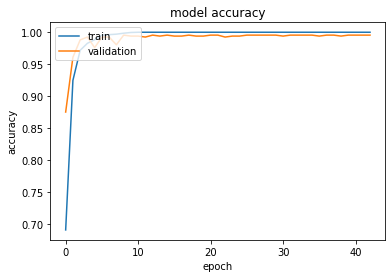

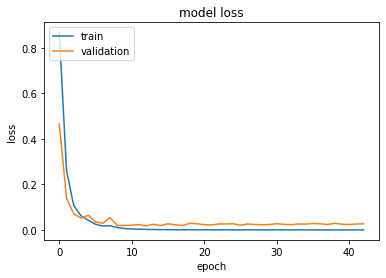

Confusion Matrix
[[18  0  4  0  2]
 [ 0 10 11  0  0]
 [ 4  0 67  8  3]
 [ 0  0  1 14  2]
 [ 0  0  0  0 29]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.82      0.75      0.78        24
         hex       1.00      0.48      0.65        21
       round       0.81      0.82      0.81        82
      square       0.64      0.82      0.72        17
    triangle       0.81      1.00      0.89        29

    accuracy                           0.80       173
   macro avg       0.81      0.77      0.77       173
weighted avg       0.82      0.80      0.79       173



In [52]:
#This model works better on independent evaluation, F1 score for each category is better, adding class weights doesnot improve th over fitting and independent evaluation is not that good in accuracy and f1 score.

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=30,verbose=1,restore_best_weights=True)


#create model
model_2layer = Sequential()
create_1(model_2layer,'sgd')
# Train model on dataset
hist=model_2layer.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=150,verbose=0)
eval_m(model_2layer)
newplot(hist)
ind_eval(hist)

print("\n")
print("********************same as above model with class weights and early stopping*************************")
print("\n")

#create model
model_2layer_v1=Sequential()
create_1(model_2layer_v1,'sgd')


# Train model on dataset
hist_1=model_2layer_v1.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_v1)
newplot(hist_1)
ind_eval(hist_1)


#create model
model_2layer_v2=Sequential()
create_1(model_2layer_v2,'adam')


# Train model on dataset
hist_2=model_2layer_v2.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_v2)
newplot(hist_2)
ind_eval(hist_2)

### 

##### Model with drop outs

In [53]:
def create_2(model,opt='sgd'):
    
    model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(28,28,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), padding='same'))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))
    if opt=='sgd':
        optimizers.SGD(lr=0.01)
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    if opt=='adam':
        optimizers.Adam(lr=0.01)
        model.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])



  ...
    to  
  ['...']
Confusion Matrix
[[ 21   0   0   0   0]
 [  1   7   1   0   0]
 [  0   0 171   0   0]
 [  0   0   0  75   0]
 [  0   0   0   1  93]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.95      1.00      0.98        21
         hex       1.00      0.78      0.88         9
       round       0.99      1.00      1.00       171
      square       0.99      1.00      0.99        75
    triangle       1.00      0.99      0.99        94

    accuracy                           0.99       370
   macro avg       0.99      0.95      0.97       370
weighted avg       0.99      0.99      0.99       370



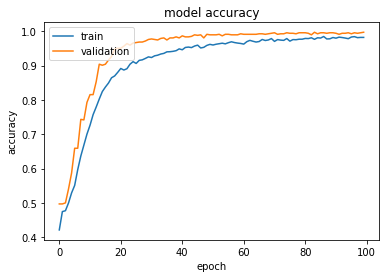

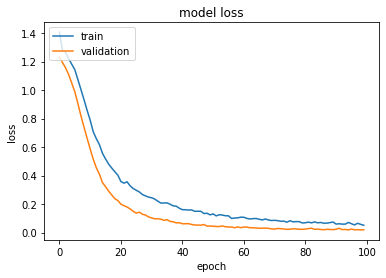

Confusion Matrix
[[20  0  2  0  2]
 [ 0  1 20  0  0]
 [ 4  0 66  9  3]
 [ 0  0  0 13  4]
 [ 0  0  0  0 29]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.83      0.83      0.83        24
         hex       1.00      0.05      0.09        21
       round       0.75      0.80      0.78        82
      square       0.59      0.76      0.67        17
    triangle       0.76      1.00      0.87        29

    accuracy                           0.75       173
   macro avg       0.79      0.69      0.65       173
weighted avg       0.78      0.75      0.71       173



********************same as above model with class weights and early stopping*************************


  ...
    to  
  ['...']
Confusion Matrix
[[ 21   0   0   0   0]
 [  0   9   0   0   0]
 [  0   0 171   0   0]
 [  0   0   0  75   0]
 [  0   0   0   0  94]]
Classification Report
              precision    recall  f1-score   support

    diamonds       1.00      1.00      

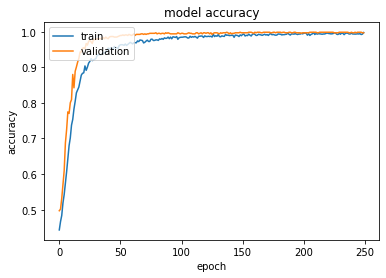

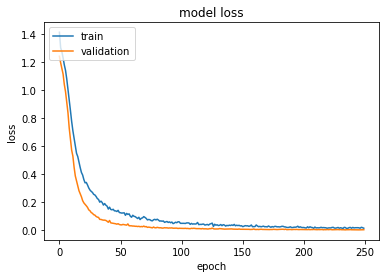

Confusion Matrix
[[17  0  6  0  1]
 [ 0  6 15  0  0]
 [ 3  0 71  6  2]
 [ 0  0  0 15  2]
 [ 0  0  0  0 29]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.85      0.71      0.77        24
         hex       1.00      0.29      0.44        21
       round       0.77      0.87      0.82        82
      square       0.71      0.88      0.79        17
    triangle       0.85      1.00      0.92        29

    accuracy                           0.80       173
   macro avg       0.84      0.75      0.75       173
weighted avg       0.82      0.80      0.78       173



********************same as above model with class weights and early stopping optimizer =adam*************************


  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Confusion Matrix
[[ 21   0   0   0   0]
 [  0   8   1   0   0]
 [  0   0 170   1   0]
 [  0   0   0  74   1]
 [  0   0   0   0  94]]
Classification R

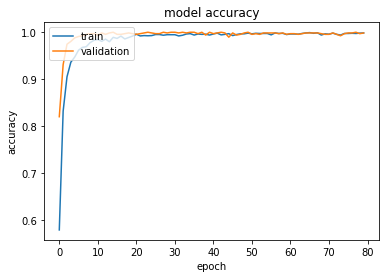

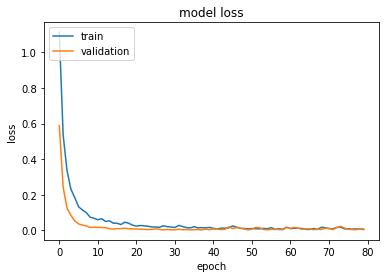

Confusion Matrix
[[20  0  4  0  0]
 [ 0  3 18  0  0]
 [ 4  0 76  2  0]
 [ 0  0  1 14  2]
 [ 0  0  0  0 29]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.83      0.83      0.83        24
         hex       1.00      0.14      0.25        21
       round       0.77      0.93      0.84        82
      square       0.88      0.82      0.85        17
    triangle       0.94      1.00      0.97        29

    accuracy                           0.82       173
   macro avg       0.88      0.75      0.75       173
weighted avg       0.84      0.82      0.79       173



In [54]:

#create model
model_2layer = Sequential()
create_2(model_2layer,opt='sgd')

# Train model on dataset
histd=model_2layer.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=100,verbose=0)
eval_m(model_2layer)
newplot(histd)
ind_eval(histd)
#epoch50 accuracy -71
#epoch100 accuracy -81
#epoch150 accuracy -89
#epoch200 accuracy -92
#epoch250 accuracy -92
#No class weights given there fore the minority class 'hex' is being predicted worng in the independent test set.

print("\n")
print("********************same as above model with class weights and early stopping*************************")
print("\n")

#create model
model_2layer_v1=Sequential()
create_2(model_2layer_v1,opt='sgd')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=50,verbose=1,restore_best_weights=True)

# Train model on dataset
histd_1=model_2layer_v1.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_v1)
newplot(histd_1)
ind_eval(histd_1)



print("\n")
print("********************same as above model with class weights and early stopping optimizer =adam*************************")
print("\n")

#create model
model_2layer_ad=Sequential()
create_2(model_2layer_ad,opt='adam')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=30,verbose=1,restore_best_weights=True)

# Train model on dataset
histd_2=model_2layer_ad.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_2layer_ad)
newplot(histd_2)
ind_eval(histd_2)



In [55]:


def create_3(model_cnn,opt='sgd'):

    # input
    model_cnn.add(Input(shape=(28, 28, 3)))
    model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    # Conv Layer 1
    model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Layer 2 
    model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))

    # Conv Layer 3
    model_cnn.add(Conv2D(64, (3, 3)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # MLP
    model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model_cnn.add(Dense(64))
    model_cnn.add(Activation('relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(5))
    model_cnn.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[categorical_accuracy])

    if opt=='sgd':
        model_cnn.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    if opt=='adam':
        model_cnn.compile(optimizer=opt,loss="categorical_crossentropy", metrics=["categorical_accuracy"])

    model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_20 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_62 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_63 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 9, 9, 64)        

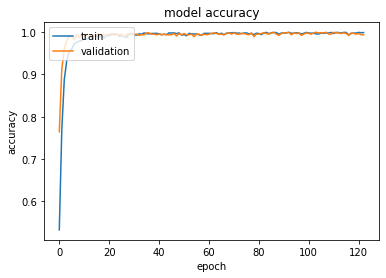

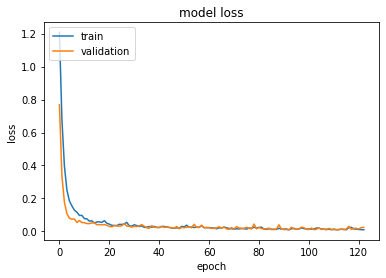

Confusion Matrix
[[21  0  2  0  1]
 [ 0 18  3  0  0]
 [ 3  0 70  7  2]
 [ 0  0  0 15  2]
 [ 0  0  0  0 29]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.88      0.88      0.88        24
         hex       1.00      0.86      0.92        21
       round       0.93      0.85      0.89        82
      square       0.68      0.88      0.77        17
    triangle       0.85      1.00      0.92        29

    accuracy                           0.88       173
   macro avg       0.87      0.89      0.88       173
weighted avg       0.90      0.88      0.89       173



In [60]:
#create model
model_cnn_3=Sequential()
create_3(model_cnn_3,opt='adam')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=30,verbose=1,restore_best_weights=True)

# Train model on dataset
histd3_2=model_cnn_3.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_cnn_3)
newplot(histd3_2)
ind_eval(histd3_2)



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_19 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_57 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_58 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 9, 9, 64)        

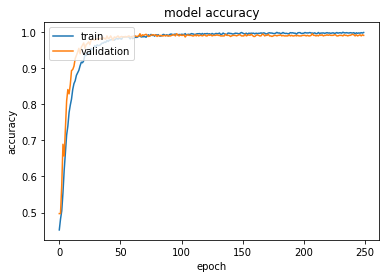

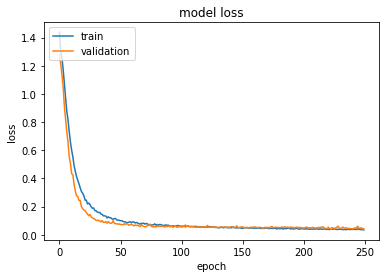

Confusion Matrix
[[17  0  7  0  0]
 [ 0 18  3  0  0]
 [ 3  0 72  4  3]
 [ 0  0  0 15  2]
 [ 0  0  0  0 29]]
Classification Report
              precision    recall  f1-score   support

    diamonds       0.85      0.71      0.77        24
         hex       1.00      0.86      0.92        21
       round       0.88      0.88      0.88        82
      square       0.79      0.88      0.83        17
    triangle       0.85      1.00      0.92        29

    accuracy                           0.87       173
   macro avg       0.87      0.87      0.87       173
weighted avg       0.88      0.87      0.87       173



In [59]:
#create model
model_cnn_3=Sequential()
create_3(model_cnn_3,opt='sgd')

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=50,verbose=1,restore_best_weights=True)

# Train model on dataset
histd3_2=model_cnn_3.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0,
                    class_weight=class_weight)
eval_m(model_cnn_3)
newplot(histd3_2)
ind_eval(histd3_2)

